In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import datetime
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patheffects as pe
from itertools import combinations_with_replacement
from dataclasses import dataclass
from collections.abc import Callable
from tqdm import tqdm
from scipy.stats import chi2

from cost import *
from data import *
from plotting import *
from regression import *
from utils import *


In [3]:
#@markdown Select the subset of the database to analyze. Either notable models, frontier models, OpenAI or Google Deepmind

filter_alphago_outliers = False #@param {type:"boolean"}
frontier_selection = 'external' #@param ['disabled', 'internal', 'external']
top_n = 10 #@param
model_selection = 'Notable models' #@param ['Google DeepMind models', 'OpenAI models', 'Meta AI models', 'Notable models', 'Language models']
cutoff_date = '2010-01-01' # '2017-06-01' # #@param
cost_cutoff_date = '2012-01-01'  # '2018-01-01'
estimation_method = 'hardware-capex-energy'
dep_var = 'log_cost'  # log_flop, log_cost
exclude_models_containing = [] # ['GNMT', 'AlphaZero', 'AlphaGo Master', 'AlphaGo Zero']
estimation_method_lookup = {
    'hardware-capex-energy': estimate_hardware_capex_energy,
    'hardware-acquisition': estimate_hardware_acquisition_cost,
    'cloud': estimate_cloud_costs,
}
cost_estimation_function = estimation_method_lookup[estimation_method]

In [4]:
# Load PCD data
df = load_pcd_df()
df.head()

,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Training compute lower bound,Training compute upper bound,Training chip-hours,Code accessibility,Dataset accessibility,Accessibility notes,Organization categorization (from Organization),Possibly over 1e23 FLOP,Training cost trends 2,Training cost trends 3
0,Chameleon-34B,"Multimodal,Image generation,Language,Vision","Language modelling/generation,Vision-language ...","Srinivasan Iyer, Bernie Huang, Lili Yu, Arun B...",NaN,NaN,Unreleased,https://arxiv.org/abs/2405.09818v1,NaN,Chameleon: Mixed-Modal Early-Fusion Foundation...,...,NaN,NaN,NaN,NaN,NaN,NaN,Industry,NaN,NaN,NaN
1,Chameleon-7B,"Multimodal,Image generation,Vision,Language","Language modelling/generation,Vision-language ...","Srinivasan Iyer, Bernie Huang, Lili Yu, Arun B...",NaN,NaN,Unreleased,https://arxiv.org/abs/2405.09818v1,NaN,Chameleon: Mixed-Modal Early-Fusion Foundation...,...,NaN,NaN,NaN,NaN,NaN,NaN,Industry,NaN,NaN,NaN
2,Yi-Large,Language,"Chat,Language modelling/generation",NaN,NaN,NaN,API access,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Industry,checked,NaN,NaN
3,Fugaku-LLM,Language,"Language modelling,Translation,Japanese langua...",NaN,NaN,NaN,Open source,https://www.fujitsu.com/global/about/resources...,NaN,Release of “Fugaku-LLM” – a large language mod...,...,NaN,NaN,NaN,NaN,NaN,NaN,"Academia,Industry",NaN,NaN,NaN
4,Gemini 1.5 Flash,"Multimodal,Language,Vision,Audio","Chat,Audio speech recognition,Image captioning...",Gemini Team,NaN,NaN,API access,https://storage.googleapis.com/deepmind-media/...,NaN,Gemini 1.5: Unlocking multimodal understanding...,...,NaN,NaN,NaN,NaN,NaN,NaN,Industry,NaN,NaN,NaN


In [5]:
#@title Analysis of the compute growth

def find_top_models_up_to_release(df, top_n):
    """Find the models which were in the top n by compute when they were released."""

    # This set will keep track of models that were ever in the top 10 at their release
    ever_in_top_n = set()

    # Iterate over each date in the DataFrame
    for current_date in df['date'].unique():
        # Get all entries up to the current date
        historical_data = df[df['date'] <= current_date]
        # Find top 10 models by flop count in this subset
        top_n_models = historical_data.nlargest(top_n, 'flop')['System']
        # Update the set of models that were ever in top n
        ever_in_top_n.update(top_n_models)

    # Return DataFrame filtered to only include models that were ever in the top 10
    return df[df['System'].isin(ever_in_top_n)]

# Filter out NaNs and sort by date
df_filtered = (df
    .rename(columns={'Training compute (FLOP)': 'flop', 'Publication date': 'date'})
    .dropna(subset=['date', 'flop'])
    .assign(date=lambda x: pd.to_datetime(x['date']), log_flop=lambda x: np.log10(x['flop']))
    .sort_values('date'))

df_notable = df_filtered.copy() # Store a copy for Top N sensitivity analysis

# Drop Alpha Go Master / Zero
if filter_alphago_outliers:
    mask = (df_filtered["System"] == 'AlphaGo Master') | (df_filtered["System"] == 'AlphaGo Zero')
    df_filtered = df_filtered[~mask]

# Filter top models
if frontier_selection == 'external':
    df_filtered = find_top_models_up_to_release(df_filtered, top_n)

# Filter models depending on analysis
if model_selection == 'Google DeepMind models':
    re = 'DeepMind|Google'
    mask = df_filtered['Organization'].str.contains(re, na=False)
    df_filtered = df_filtered[mask]
elif model_selection == 'OpenAI models':
    re = 'OpenAI'
    mask = df_filtered['Organization'].str.contains(re, na=False)
    df_filtered = df_filtered[mask]
    # Exclude ADAM (retroactively attributed to OpenAI but published before its foundation)
    df_filtered = df_filtered[df_filtered['System'] != 'ADAM (CIFAR-10)']
elif model_selection == 'Meta AI models':
    re = 'Meta AI|Facebook|FAIR'
    mask = df_filtered['Organization'].str.contains(re, na=False)
    df_filtered = df_filtered[mask]
elif model_selection == 'Language models':
    re = 'Language|Multimodal'
    mask = df_filtered['Domain'].str.contains(re, na=False)
    df_filtered = df_filtered[mask]

# Filter top models
if frontier_selection == 'internal':
    df_filtered = find_top_models_up_to_release(df_filtered, top_n)

# Filter for models after the cutoff date
df_filtered = df_filtered[df_filtered['date'] > cutoff_date]

print(f"{len(df_filtered)}{' top' if frontier_selection != 'disabled' else ''} {model_selection} found")
print(f"They span {df_filtered['date'].min().strftime('%B %Y')} to {df_filtered['date'].max().strftime('%B %Y')}")

97 top Notable models found
They span March 2010 to April 2024


In [6]:
# Run the cost estimation pipeline

# Hack: undo the column renaming for the cost pipeline
df_filtered = df_filtered.rename(columns={'flop': 'Training compute (FLOP)', 'date': 'Publication date'})

price_df = load_price_df()
# Price date in datetime format
price_df.dropna(subset=['Price date'], inplace=True)
price_df['Price date'] = pd.to_datetime(price_df['Price date'])
pcd_hardware_model_colname = 'Name of the hardware (from Training hardware)'

hardware_df = load_hardware_df()

cost_df = cost_estimation_function(df_filtered, hardware_df, price_df)
cost_df = adjust_column_for_inflation(cost_df, 'Cost', 'data/PCU518210518210.csv', '2023-12-01')

for kw in exclude_models_containing:
    cost_df = cost_df[cost_df['System'].str.contains(kw) == False]

cost_df = cost_df[cost_df['Publication date'] > cost_cutoff_date]

df_filtered = cost_df
# Redo the column renaming
df_filtered = df_filtered.rename(columns={
    'Training compute (FLOP)': 'flop',
    'Publication date': 'date',
    'Cost (inflation-adjusted)': 'cost',
})
df_filtered = df_filtered.assign(log_cost=lambda x: np.log10(x['cost']))

==== System: 6-layer MLP (MNIST) ====
Could not find hardware model for 6-layer MLP (MNIST)

==== System: Feedforward NN ====
Could not find hardware model for Feedforward NN

==== System: RNN 500/10 + RT09 LM (NIST RT05) ====
Could not find hardware model for RNN 500/10 + RT09 LM (NIST RT05)

==== System: KN5 LM + RNN 400/10 (WSJ) ====
Could not find hardware model for KN5 LM + RNN 400/10 (WSJ)

==== System: MCDNN (MNIST) ====
Could not find hardware model for MCDNN (MNIST)

==== System: Dropout (ImageNet) ====
Estimated the value of NVIDIA GeForce GTX 580 server, available from 2011-02-07 00:00:00 and used from 2012-03-31 00:00:00: 565.8813300261663 per chip

==== System: Dropout (CIFAR) ====
Estimated the value of NVIDIA GeForce GTX 580 server, available from 2011-02-07 00:00:00 and used from 2012-04-03 23:00:00: 564.3850072096027 per chip

==== System: Dropout (MNIST) ====
No training time found, assuming 33.0625

Estimated the value of NVIDIA GeForce GTX 580 server, available from

In [7]:
if dep_var == 'log_cost' or dep_var == 'log_flop':
    df_filtered = df_filtered.dropna(subset=['date', 'flop', 'cost'])
    df_filtered = df_filtered[['System', 'date', 'log_cost', 'log_flop', 'cost', 'flop', 'Organization', 'Notability criteria', 'Domain']]
elif dep_var == 'log_training_time':
    df_filtered = df_filtered.dropna(subset=['date', 'Training time (hours)'])
    df_filtered['log_training_time'] = np.log10(df_filtered['Training time (hours)'])
    df_filtered = df_filtered[['System', 'date', 'log_training_time', 'log_cost', 'log_flop', 'cost', 'flop', 'Organization', 'Notability criteria', 'Domain']]

df_filtered

,System,date,log_cost,log_flop,cost,flop,Organization,Notability criteria,Domain
1329,Dropout (ImageNet),2012-06-03,0.883920,17.436476,7.654551e+00,2.731968e+17,University of Toronto,Highly cited,Vision
1330,Dropout (CIFAR),2012-06-03,-0.922816,15.630296,1.194495e-01,4.268700e+15,University of Toronto,Highly cited,Vision
1331,Dropout (MNIST),2012-06-03,-0.765968,15.780992,1.714082e-01,6.039371e+15,University of Toronto,Highly cited,Vision
1322,AlexNet,2012-09-30,1.102568,17.672098,1.266392e+01,4.700000e+17,University of Toronto,"Highly cited,Historical significance",Vision
1302,Visualizing CNNs,2013-11-12,1.097156,17.725912,1.250708e+01,5.320000e+17,New York University (NYU),Highly cited,Vision
1280,SPPNet,2014-06-18,1.696501,18.532891,4.971654e+01,3.411072e+18,"Microsoft,Xi’an Jiaotong University,University...",Highly cited,Vision
1272,VGG16,2014-09-04,2.140588,18.966303,1.382255e+02,9.253440e+18,University of Oxford,Highly cited,Vision
1228,DeepSpeech2 (English),2015-12-08,2.314511,19.414973,2.063058e+02,2.600000e+19,Baidu Research - Silicon Valley AI Lab,Highly cited,Speech
1180,GNMT,2016-09-26,5.287325,21.820858,1.937871e+05,6.620000e+21,Google,Highly cited,Language
1179,Xception,2016-10-07,4.100978,20.639486,1.261763e+04,4.360000e+20,Google,Highly cited,Vision


In [8]:
len(df_filtered)

52

In [9]:
#@markdown Analysis of best fit to the data

@dataclass
class FitResult:
    df: pd.DataFrame
    p: int = None
    bic: float = None
    rss: float = None
    mse: float = None
    predict: Callable = None

@dataclass
class HyperbolicFitResult(FitResult):
    params: tuple[float] = None

@dataclass
class KinkedFitResult(FitResult):
    break_points: tuple[float] = None
    break_points_dt: float = None
    oom_year_slopes: tuple[float] = None

    # Model properties for each breakpoint combination
    # (for debugging)
    bics: tuple[float] = None
    rsss: tuple[float] = None
    mses: tuple[float] = None
    break_points_list: tuple[tuple[float]] = None
    break_points_dt_list: tuple[tuple[float]] = None

def fit_hyperbolic(df):
    def hyperbolic_model(t, A, B, k):
        return A / (1 + B * np.exp(-k * t))

    # Prepare data for curve fitting
    timestamp = pd.to_datetime(df['date']).apply(lambda date: date.toordinal()).values

    # Initial guess for the parameters
    # initial_guess = [0, 0, 0]
    initial_guess = [1.72373207e-02, -9.45447534e-01, -7.50101861e-08]  # Updated initial guess

    # Fit the model to the data
    try:
      params, covariance = curve_fit(hyperbolic_model, timestamp, df[dep_var], p0=initial_guess, maxfev=100000, ftol=1e-10)
    except RuntimeError as e:
      print("FATAL ERROR WHEN FITTING HYPERBOLIC")
      return None

    # Extracting parameters
    A, B, k = params

    # Compute predictions to calculate residuals
    predicted_log_y = hyperbolic_model(timestamp, *params)

    # Compute the Residual Sum of Squares (RSS)
    rss = np.sum((df[dep_var] - predicted_log_y) ** 2)

    # Number of observations (n)
    n = len(df[dep_var])

    # Number of parameters (p)
    p = len(params) + 1

    # Calculate log-likelihood under the assumption of normally distributed errors
    # log_likelihood = -0.5 * rss
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * rss/n) + 1)

    # Compute bic_hyperbolic using the provided formula
    bic = p * np.log(n) - 2 * log_likelihood

    # Compute MSE
    mse = rss / n

    fit_result = HyperbolicFitResult(
        df=df,
        p=p,
        bic=bic,
        rss=rss,
        mse=mse,
        params=params,
        predict=lambda date: hyperbolic_model(date.apply(lambda d: d.toordinal()), *params)
    )

    return fit_result

def fit_n_phase_exponential(df, kink_count, allow_discontinuities=False, min_n_segment = 5):
    # Generate monthly breakpoints between 2010 and 2024
    one_month = pd.DateOffset(months=1)
    break_point_grid = pd.date_range(start=df['date'].min() - one_month, end=df['date'].max() - 4*one_month, freq='MS')
    break_point_grid = [x.toordinal() for x in break_point_grid]

    x = pd.to_datetime(df['date']).apply(lambda date: date.toordinal()).values
    y = df[dep_var].values

    break_points_list = []
    bics = []
    rsss = []
    mses = []
    models = []

    for break_points in combinations_with_replacement(break_point_grid, kink_count):
        # Model predictors

        intercept_change_points = (0,)
        if allow_discontinuities:
            intercept_change_points += break_points
        slope_change_points = (0,) + break_points

        predictors = np.zeros((len(x), len(intercept_change_points) + len(slope_change_points)))

        for i, intercept_point in enumerate(intercept_change_points):
            predictors[:, i] = (x >= intercept_point).astype(int)

        for i, break_point in enumerate(slope_change_points):
            predictors[:, len(intercept_change_points) + i] = np.maximum(x - break_point, 0)

        # Fit the model
        model = sm.OLS(y, predictors).fit()

        # Calculate BIC manually based on log-likelihood
        n = len(x) # Number of observations
        p = len(model.params) + 2*kink_count + 1 # Number of parameters

        # Calculate log-likelihood under the assumption of normally distributed errors
        # We have to iterate over all points to get their individual log-likelihoods
        log_likelihood = 0
        rss = 0
        invalid_model = False # Discard models with segments with less than 2 points
        for i, break_point in enumerate(slope_change_points):
            left_x = break_point
            right_x = slope_change_points[i + 1] if i + 1 < len(slope_change_points) else np.inf

            segment_predictors = predictors[(left_x <= x) & (x < right_x), :]
            segment_y = y[(left_x <= x) & (x < right_x)]
            segment_n = len(segment_y)

            assert min_n_segment > 2

            if segment_n < min_n_segment:
                invalid_model = True
                break

            y_pred = model.predict(segment_predictors)

            segment_rss = np.sum((y_pred - segment_y)**2)
            assert segment_rss > 0
            segment_mse = segment_rss / segment_n

            segment_log_likelihood = -segment_n/2 * (np.log(2*np.pi) + np.log(segment_rss/segment_n) + 1)
            log_likelihood += segment_log_likelihood
            rss += segment_rss

        if invalid_model:
            continue

        # Compute BIC using the manual method based on the log-likelihood
        bic = p * np.log(n) - 2 * log_likelihood
        # bic = n*np.log(rss/n) + p*np.log(n)

        bics.append(bic)
        rsss.append(rss)
        mses.append(rss/len(df))
        models.append(model)
        break_points_list.append(break_points)

    # Prepare the result object
    best_bic = min(bics)
    best_idx = bics.index(best_bic)
    best_rss = rsss[best_idx]
    best_mse = mses[best_idx]
    best_model = models[best_idx]
    best_break_points = break_points_list[best_idx]

    p = len(best_model.params) + 2*kink_count + 1 # Number of parameters

    intercept_change_points = (0,)
    if allow_discontinuities:
        intercept_change_points += best_break_points
    slope_change_points = (0,) + best_break_points

    intercepts = best_model.params[:len(intercept_change_points)]
    oom_year_slopes = 365 * np.cumsum(best_model.params[len(intercepts):])

    def predict(date):
        if not isinstance(date, pd.Series):
            date = pd.Series(date)
        x = pd.to_datetime(date).apply(lambda date: date.toordinal()).values

        predictors = np.zeros((len(x), len(intercept_change_points) + len(slope_change_points)))

        for i, intercept_point in enumerate(intercept_change_points):
            predictors[:, i] = (x >= intercept_point).astype(int)

        for i, break_point in enumerate(slope_change_points):
            predictors[:, len(intercept_change_points) + i] = np.maximum(x - break_point, 0)

        return best_model.predict(predictors)

    fit_result = KinkedFitResult(
        df=df,
        p=p,
        bic=best_bic,
        rss=best_rss,
        mse=best_mse,
        break_points=best_break_points,
        predict=predict,
        break_points_dt=[pd.Timestamp.fromordinal(bp) for bp in best_break_points],
        bics=bics,
        rsss=rsss,
        mses=mses,
        oom_year_slopes=oom_year_slopes,
        break_points_list=break_points_list,
        break_points_dt_list=[[pd.Timestamp.fromordinal(bp) for bp in break_points] for break_points in break_points_list],
    )

    return fit_result

fit_em_all = lambda df_fit : {
    "Simple" : fit_n_phase_exponential(df_fit, kink_count=0),
    "Discrete acceleration" : fit_n_phase_exponential(df_fit, kink_count=1),
    "Discontinuity" : fit_n_phase_exponential(df_fit, kink_count=1, allow_discontinuities=True),
    # "Hyperbolic": fit_hyperbolic(df_fit),
}

# Best model fits
models = fit_em_all(df_filtered)

# K-Fold Cross Validation

from sklearn.model_selection import KFold
from collections import defaultdict

def perform_cross_validation(df, k=10, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    folds_mses = defaultdict(lambda : [])
    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index], df.iloc[test_index]

        # Fit the models on the training set
        fold_models = fit_em_all(train_df)

        # Predict on the test set
        for name,model in fold_models.items():
            try:
                predicted_log_y = model.predict(test_df["date"])
            except AttributeError:
                continue
            test_rss = np.sum((predicted_log_y - test_df[dep_var])**2)
            test_mse = test_rss / len(test_df)
            folds_mses[name].append(test_mse)

    # Compute mean MSE
    folds_mses = {name: np.mean(folds_mses[name]) for name in folds_mses}

    return folds_mses

folds_mses = perform_cross_validation(df_filtered)

# Bootstrap
bootstrap_sample_size = 1000 #@param

rng = np.random.default_rng(43)
bootstrap_bics = defaultdict(lambda : [])
bootstrap_mses = defaultdict(lambda : [])
bootstrap_bic_score_diff = defaultdict(lambda : [])
bootstrap_slopes = defaultdict(lambda : [])
bootstrap_breaks = defaultdict(lambda : [])
for bootstrap_index in tqdm(range(bootstrap_sample_size)):
    sample = df_filtered.sample(len(df_filtered), replace=True, random_state=rng)
    sample = sample.sort_values('date')

    # Compute BICs
    boot_models = fit_em_all(sample)

    # Compute K fold validation
    boot_folds_mses = perform_cross_validation(sample)

    # Store results
    for name, model in boot_models.items():
        # It might be None if the hyperbolic fails to fit
        if model is None: continue

        bootstrap_bics[name].append(model.bic)
        bootstrap_mses[name].append(boot_folds_mses[name])
        bootstrap_bic_score_diff[name].append(model.bic - boot_models["Simple"].bic)

        if isinstance(model, KinkedFitResult):
            if (len(model.oom_year_slopes) > 0): bootstrap_slopes[name].append(10**model.oom_year_slopes[-1])
            if (len(model.break_points_dt) > 0): bootstrap_breaks[name].append(model.break_points_dt[-1])

ci_width = 0.90
qs = [(1 - ci_width)/2, (1 + ci_width)/2]
bootstrap_preferred_percent = {}
for name in models:
    bootstrap_preferred_percent[name] = np.mean(np.array(bootstrap_bic_score_diff[name])<0)
    bootstrap_bics[name] = np.quantile(np.array(bootstrap_bics[name]), qs)
    bootstrap_mses[name] = np.quantile(np.array(bootstrap_mses[name]), qs)
    bootstrap_bic_score_diff[name] = np.quantile(np.array(bootstrap_bic_score_diff[name]), qs)
    try:
        bootstrap_slopes[name] = np.quantile(np.array(bootstrap_slopes[name]), qs)
        bootstrap_breaks[name] = np.quantile(np.array(bootstrap_breaks[name]), qs)
    except IndexError:
        pass
#@markdown Models with lower BIC score / MSE are preferred.

results = []
for name, model in models.items():
    param_count = model.p
    log_likelihood = (np.log(len(df_filtered))*param_count - model.bic)/2

    param_count_simple = models['Simple'].p
    log_likelihood_simple = (np.log(len(df_filtered))*param_count_simple - models['Simple'].bic)/2

    c2 = chi2.sf(2*(log_likelihood - log_likelihood_simple), df=(param_count - param_count_simple))

    result = {
        "Model": name,
        "BIC" : np.round(model.bic, 2),
        "BIC 90% CI" : np.round(bootstrap_bics[name], 2),
        #"Parameter count": param_count,
        #"Log likelihood": np.round((np.log(len(df_filtered))*param_count - model.bic)/2),
        # "MSE" : model.mse,
        "BIC score diff": np.round(model.bic - models["Simple"].bic, 2),
        "BIC score diff 90% CI": np.round(bootstrap_bic_score_diff[name], 2),
        "Xi²": c2,
        "% times preferred over simple": f"{bootstrap_preferred_percent[name]:.0%}",
        # "bayes factor over simple" : np.exp(-0.5 * (model.bic - models["simple"].bic)),
        "K-fold mean MSE" : np.round(folds_mses[name], 2),
        "K-fold mean MSE 90% CI" : np.round(bootstrap_mses[name], 2),
    }

    try:
        result["Recent slope (Nx/year)"] = np.round(10**model.oom_year_slopes[-1], 2)
        result["Recent slope 90% CI"] = np.round(bootstrap_slopes[name], 2)
        result["Break point"] = model.break_points_dt[-1].strftime('%Y-%m')
        result["Break point 90% CI"] = [date.strftime('%Y-%m') for date in bootstrap_breaks[name]]
    except (AttributeError, IndexError):
        pass
    results.append(result)

results_df = pd.DataFrame(results)

# bayes_factor = np.exp(-0.5 * (kinked_fit.bic - simple_fit.bic))

print("Results")
results_df

100%|██████████| 1000/1000 [04:16<00:00,  3.89it/s]

Results


,Model,BIC,BIC 90% CI,BIC score diff,BIC score diff 90% CI,Xi²,% times preferred over simple,K-fold mean MSE,K-fold mean MSE 90% CI,Recent slope (Nx/year),Recent slope 90% CI,Break point,Break point 90% CI
0,Simple,137.55,"[109.31, 153.93]",0.00,"[0.0, 0.0]",NaN,0%,0.73,"[0.41, 0.98]",3.44,"[2.88, 3.91]",NaN,NaN
1,Discrete acceleration,128.39,"[94.68, 135.96]",-9.17,"[-38.93, 0.9]",0.000104,94%,0.56,"[0.37, 0.77]",2.35,"[1.85, 4.23]",2017-02,"[2012-12, 2023-05]"
2,Discontinuity,121.54,"[-69.56, 126.71]",-16.02,"[-205.17, -5.57]",0.000002,99%,0.58,"[0.33, 0.76]",3.23,"[1.98, 6.03]",2018-02,"[2014-01, 2023-01]"


In [10]:
for name, model in models.items():
    print(name, bootstrap_slopes[name])

Simple [2.8840928  3.90834779]
Discrete acceleration [1.85473357 4.22893316]
Discontinuity [1.97555508 6.0340793 ]


The breakpoints are: [2017-02-01]
The slopes are: [0.91, 0.37] OOM/year ([8.08, 2.35] x/year)
BIC score: 128.38626165550818
This fit is preferred over a simple exponential by a BIC score difference of -265.94021293442916


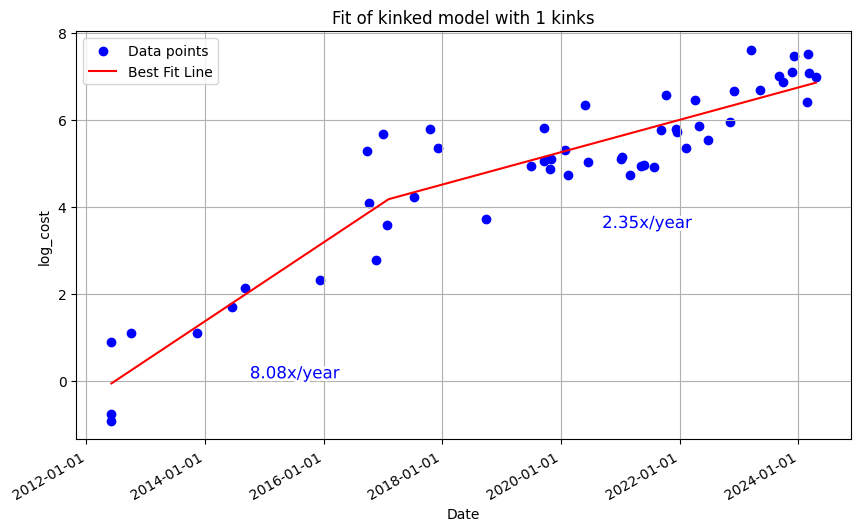

In [14]:
#@markdown Graph of the different model fits

model = 'kinked' #@param ['simple', 'kinked', 'hyperbolic']

#@markdown Parameters for the kinked model
kink_count = 1 #@param {type:'integer'}
allow_discontinuities = False #@param {type:'boolean'}

def plot_model(df, model_type, kink_count=1, verbose=True):
    if model_type == 'hyperbolic':
        fit_result = fit_hyperbolic(df)
    elif model_type == 'simple':
        fit_result = fit_n_phase_exponential(df, 0)
    else:
        fit_result = fit_n_phase_exponential(df, kink_count, allow_discontinuities)

    log_y = fit_result.predict(df['date'])

    # Plot the original data points
    plt.figure(figsize=(10, 6))
    plt.scatter(df['date'], df[dep_var], color='blue', label='Data points')

    date_grid = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
    log_y = fit_result.predict(pd.Series(date_grid)) # we shouldn't need to convert to a Series
    plt.plot(date_grid, log_y, color='red', label='Best Fit Line')


    # Formatting the plot
    plt.legend()
    if model == 'kinked':
      plt.title(f'Fit of {model_type} model with {kink_count} kinks')
    else:
      plt.title(f'Fit of {model_type} model')
    plt.xlabel('Date')
    plt.ylabel(dep_var)

    # Format the date on the x-axis
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Rotation

    if model == 'kinked' or model == 'simple':
        if kink_count == 0 or model == 'simple':
            print(f"The slope is: {fit_result.oom_year_slopes[0]:0.2f} OOM/year ({10**fit_result.oom_year_slopes[0]:0.2f}x/year)")
        else:
            oom_year_slopes_str = ', '.join([f'{x:0.2f}' for x in fit_result.oom_year_slopes])
            nx_year_slopes_str = ', '.join([f'{10**x:0.2f}' for x in fit_result.oom_year_slopes])
            break_points_str = ', '.join([bp.strftime('%Y-%m-%d') for bp in fit_result.break_points_dt])

            print(f"The breakpoints are: [{break_points_str}]")
            print(f"The slopes are: [{oom_year_slopes_str}] OOM/year ([{nx_year_slopes_str}] x/year)")

        # Add slope labels
        points = [df['date'].min()] + fit_result.break_points_dt + [df['date'].max()]

        for i in range(len(points) - 1):
            mid = points[i] + (points[i+1] - points[i]) / 2
            y = fit_result.predict(pd.Series([mid]))[0]
            plt.text(mid, y - 2, f'{10**fit_result.oom_year_slopes[i]:0.2f}x/year', fontsize=12, color='blue', path_effects=[pe.withStroke(linewidth=4, foreground="white")])

    if verbose:
      simple_fit = fit_n_phase_exponential(df, 0)
      bayes_factor = np.exp(-0.5 * (fit_result.bic - simple_fit.bic))
      unadjusted_bayes_factor = np.exp(-0.5 * (fit_result.bic - (simple_fit.bic + 2*np.log(len(df_filtered)))))

      print(f"BIC score: {fit_result.bic}")
      bic_score_difference = fit_result.bic - simple_fit.bic
      if bic_score_difference > 0:
        print(f"The simple exponential is preferred over this fit by a BIC score difference of {fit_result.bic - simple_fit.bic}")
      if bic_score_difference < 0:
        print(f"This fit is preferred over a simple exponential by a BIC score difference of {-fit_result.bic - simple_fit.bic}")

    plt.legend()
    plt.grid(True)
    plt.show()

plot_model(df_filtered, model, kink_count)